# Exploratory Data Analysis (EDA) & Data Preparation

## 1. Load Packages and Datasets

In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import os
import re
import spacy
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from IPython.display import display, HTML
import matplotlib.colors as mcolors

# Install extra libraries
#!pip install bs4
#!pip install matplotlib

C:\Users\ebbi_\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [5]:
train_df = pd.read_json('./../data/train.json')
train_df.sample(5)

,document,full_text,tokens,trailing_whitespace,labels
1686,11032,Storytelling\n\nChallenge and Selection\n\nSto...,"[Storytelling, \n\n, Challenge, and, Selection...","[False, False, True, True, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2447,12603,Design Thinking for Innovation. A New era of ...,"[Design, Thinking, for, Innovation, ., , A, N...","[True, True, True, False, True, False, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-N..."
4607,17768,DIGITAL STORY TELLING\n\nIntroduction The tech...,"[DIGITAL, STORY, TELLING, \n\n, Introduction, ...","[True, True, False, False, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1235,10140,PWC ProEdge – Design Thinking Assignment\n\nCh...,"[PWC, ProEdge, –, Design, Thinking, Assignment...","[True, True, True, True, True, False, False, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6071,21124,Design Thinking Reflection – Mind Mapping\n\nC...,"[Design, Thinking, Reflection, –, Mind, Mappin...","[True, True, True, True, True, False, False, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [6]:
test_df = pd.read_json('./../data/test.json')
test_df.sample(5)

,document,full_text,tokens,trailing_whitespace
6,93,Silvia Villalobos\n\nChallenge:\n\nThere is a ...,"[Silvia, Villalobos, \n\n, Challenge, :, \n\n,...","[True, False, False, False, False, False, True..."
5,86,Cheese Startup - Learning Launch ​by Eladio Am...,"[Cheese, Startup, -, Learning, Launch, ​by, El...","[True, True, True, True, True, True, True, Fal..."
8,112,Reflection – Learning Launch\n\nFrancisco Ferr...,"[Reflection, –, Learning, Launch, \n\n, Franci...","[True, True, True, False, False, True, False, ..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal..."


In [52]:
#Removed Submission Sample File 
#submission_df = pd.read_csv('/Users/jvo/DataspellProjects/ADS-599-Capstone-Project/data/raw_data/sample_submission.csv')
#submission_df.head()

,row_id,document,token,label
0,0,7,9,B-NAME_STUDENT
1,1,7,10,I-NAME_STUDENT
2,2,7,482,B-NAME_STUDENT
3,3,7,483,I-NAME_STUDENT
4,4,7,741,B-NAME_STUDENT


In [7]:
pii_labels = [
    'B-NAME_STUDENT', 'I-NAME_STUDENT',
    'B-URL_PERSONAL', 'I-URL_PERSONAL',
    'B-ID_NUM', 'I-ID_NUM',
    'B-EMAIL', 'I-EMAIL',
    'B-STREET_ADDRESS', 'I-STREET_ADDRESS',
    'B-PHONE_NUM', 'I-PHONE_NUM',
    'B-USERNAME', 'I-USERNAME'
]

## 2. Exploratory Data Analysis

In [8]:
train_df.isna().sum()

document               0
full_text              0
tokens                 0
trailing_whitespace    0
labels                 0
dtype: int64

In [9]:
test_df.isna().sum()

document               0
full_text              0
tokens                 0
trailing_whitespace    0
dtype: int64

We are able to verify that neither dataset has null values that would need to be pre-processed.

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6807 entries, 0 to 6806
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             6807 non-null   int64 
 1   full_text            6807 non-null   object
 2   tokens               6807 non-null   object
 3   trailing_whitespace  6807 non-null   object
 4   labels               6807 non-null   object
dtypes: int64(1), object(4)
memory usage: 319.1+ KB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             10 non-null     int64 
 1   full_text            10 non-null     object
 2   tokens               10 non-null     object
 3   trailing_whitespace  10 non-null     object
dtypes: int64(1), object(3)
memory usage: 400.0+ bytes


We know that the train set has 6,807 rows of data and the test set only has 10 rows.

In [12]:
train_eda = train_df.copy()

# Find documnets with high number of entities
train_eda['new_labels'] = train_eda['labels'].apply(lambda x: [item for item in x if item != 'O'])
train_eda['count_new_labels'] = train_eda['new_labels'].apply(len)
train_eda['count_distinct_new_labels'] = train_eda['new_labels'].apply(lambda x: len(set(x)))
train_eda.sort_values(by='count_distinct_new_labels', inplace=True, ascending=False)

exploded_df = train_eda['new_labels'].explode()
dummies = pd.get_dummies(exploded_df).reset_index()

frequency = dummies.sum().sort_values(ascending=False)
ordered_columns = frequency.index.tolist() ; ordered_columns.remove("index")

counted = dummies.groupby('index').sum()
counted = counted.reindex(columns=pii_labels, fill_value=0)
counted = counted[ordered_columns + [i for i in pii_labels if i not in ordered_columns]]

train_eda = train_eda.join(counted)
train_eda.head()

,document,full_text,tokens,trailing_whitespace,labels,new_labels,count_new_labels,count_distinct_new_labels,B-NAME_STUDENT,I-NAME_STUDENT,B-URL_PERSONAL,B-ID_NUM,B-EMAIL,I-STREET_ADDRESS,I-PHONE_NUM,B-PHONE_NUM,B-USERNAME,B-STREET_ADDRESS,I-ID_NUM,I-URL_PERSONAL,I-EMAIL,I-USERNAME
1103,9854,Waseem Mabunda 591 Smith Centers Apt. 656\nJo...,"[Waseem, Mabunda, , 591, Smith, Centers, Apt,...","[True, True, False, True, True, True, False, T...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-STREET_A...","[B-NAME_STUDENT, I-NAME_STUDENT, B-STREET_ADDR...",15,6,1,1,1,0,0,10,0,1,0,1,0,0,0,0
219,4777,"Assignment: Reflection on Design Thinking, Sto...","[Assignment, :, Reflection, on, Design, Thinki...","[False, True, True, True, True, False, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[B-NAME_STUDENT, I-NAME_STUDENT, I-NAME_STUDEN...",8,5,1,2,0,0,1,0,3,1,0,0,0,0,0,0
350,6243,Name: Jana Telfah Email: nbarker@hotmail.com ...,"[Name, :, Jana, Telfah, , Email, :, nbarker@h...","[False, True, True, True, False, False, True, ...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O...","[B-NAME_STUDENT, I-NAME_STUDENT, B-EMAIL, B-PH...",21,5,3,3,0,0,3,0,9,3,0,0,0,0,0,0
24,379,"COURSERA – University of Virginia, Darden Scho...","[COURSERA, –, University, of, Virginia, ,, Dar...","[True, True, True, True, False, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[B-NAME_STUDENT, I-NAME_STUDENT, B-EMAIL, B-UR...",6,4,2,2,1,0,1,0,0,0,0,0,0,0,0,0
440,7308,Md Carrillo\n\nlisarose@gmail.com\n\ndiazkrist...,"[Md, Carrillo, \n\n, lisarose@gmail.com, \n\n,...","[True, False, False, False, False, False, Fals...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-EMAIL, O...","[B-NAME_STUDENT, I-NAME_STUDENT, B-EMAIL, B-EM...",10,4,2,2,2,0,4,0,0,0,0,0,0,0,0,0


In [13]:
ner_colors = {
    'B-NAME_STUDENT': 'rgb(255, 179, 179)',
    'I-NAME_STUDENT': 'rgb(139, 0, 0)',
    'B-URL_PERSONAL': 'rgb(255, 223, 179)',
    'I-URL_PERSONAL': 'rgb(255, 140, 0)',
    'B-ID_NUM': 'rgb((255, 255, 179)',
    'I-ID_NUM':  'rgb(204, 204, 0)',
    'B-EMAIL': 'rgb(179, 255, 179)',
    'I-EMAIL': 'rgb(0, 100, 0)',
    'B-STREET_ADDRESS':  'rgb(179, 223, 255)',
    'I-STREET_ADDRESS': 'rgb(0, 0, 139)',
    'B-PHONE_NUM': 'rgb(223, 179, 255)',
    'I-PHONE_NUM': 'rgb(75, 0, 130)',
    'B-USERNAME': 'rgb(255, 179, 223)',
    'I-USERNAME': 'rgb(231, 84, 128)',
}

def generate_legend():
    legend_html = '<div class="legend" style="margin-bottom: 10px;">'
    for entity, color in ner_colors.items():
        legend_html += f'<span style="color: {color}; margin-right: 10px;">{entity}</span>'
    legend_html += '</div>'
    return legend_html

def highlight_entities(text, tokens, labels):
    legend = generate_legend()  # Generate the legend
    soup = BeautifulSoup(legend, 'html.parser')  # Start with the legend

    last_idx = 0
    for token, label in zip(tokens, labels):
        start, end = text.find(token, last_idx), text.find(token, last_idx) + len(token)

        if start != -1:
            soup.append(BeautifulSoup(text[last_idx:start], 'html.parser'))

            if label != 'O':
                token_span = soup.new_tag('span', style=f'background-color: {ner_colors.get(label, "black")}; font-family: "Tahoma"; padding: 0 2px; border-radius: 3px;')
                token_span.string = token
                soup.append(token_span)

                label_span = soup.new_tag('span', style=f'background-color: {ner_colors.get(label, "black")}; font-family: Tahoma; font-weight: bold; padding: 0 2px; border-radius: 3px;')
                label_span.string = f" [{label}]"
                soup.append(label_span)
            else:
                soup.append(token)

            last_idx = end

    soup.append(BeautifulSoup(text[last_idx:], 'html.parser'))
    return str(soup).replace('\n', '<br/>')

def label_color(label):
    return ner_colors.get(label, 'black')

In [14]:
sample_train = train_eda.sample(1)

sample_train.loc[:, 'html'] = sample_train.apply(lambda x: highlight_entities(x['full_text'], x['tokens'], x['labels']), axis=1)
for html in sample_train['html']:
    display(HTML(html))

In [15]:
num_documents = train_eda.shape[0]
ner_labels_data = train_eda[pii_labels].melt(var_name='ner_label', value_name='count')
ner_labels_stat = ner_labels_data.groupby('ner_label').agg(
    doc_count=pd.NamedAgg(column='count', aggfunc=lambda x: (x > 0).sum()),
    ner_count=pd.NamedAgg(column='count', aggfunc="sum"),
).reset_index()
ner_labels_stat['doc_count_percentage'] = np.round(ner_labels_stat['doc_count']/num_documents,4)
ner_labels_stat['ner_count_percentage'] = np.round(ner_labels_stat['ner_count']/sum(ner_labels_stat['ner_count']),4)

ner_labels_stat = ner_labels_stat.sort_values('doc_count', ascending=False)

In [16]:
ner_labels_stat

,ner_label,doc_count,ner_count,doc_count_percentage,ner_count_percentage
2,B-NAME_STUDENT,891,1365,0.1309,0.4984
9,I-NAME_STUDENT,814,1096,0.1196,0.4001
5,B-URL_PERSONAL,72,110,0.0106,0.0402
1,B-ID_NUM,33,78,0.0048,0.0285
0,B-EMAIL,24,39,0.0035,0.0142
6,B-USERNAME,5,6,0.0007,0.0022
3,B-PHONE_NUM,4,6,0.0006,0.0022
10,I-PHONE_NUM,3,15,0.0004,0.0055
4,B-STREET_ADDRESS,2,2,0.0003,0.0007
11,I-STREET_ADDRESS,2,20,0.0003,0.0073


In [17]:
def plot_ner_distribution(ner_labels_stat, count_col, percentage_col):

    plt.figure(figsize=(16,8))
    unique_labels = ner_labels_stat['ner_label'].unique()
    colors = plt.cm.hsv(np.linspace(0, 1, len(unique_labels)))
    color_dict = dict(zip(unique_labels, colors))

    for label in unique_labels:
        subset = ner_labels_stat[ner_labels_stat['ner_label'] == label]
        plt.bar(subset['ner_label'], subset[count_col], color=color_dict[label])

    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Create secondary y-axis for percentage
    sec_axis = plt.twinx()
    sec_axis.plot(ner_labels_stat['ner_label'], ner_labels_stat[percentage_col], color='r')
    sec_axis.set_ylabel('Percentage')

    # Titles and labels
    plt.title('Count / Percentage of NER Labels')
    plt.xlabel('NER Label')

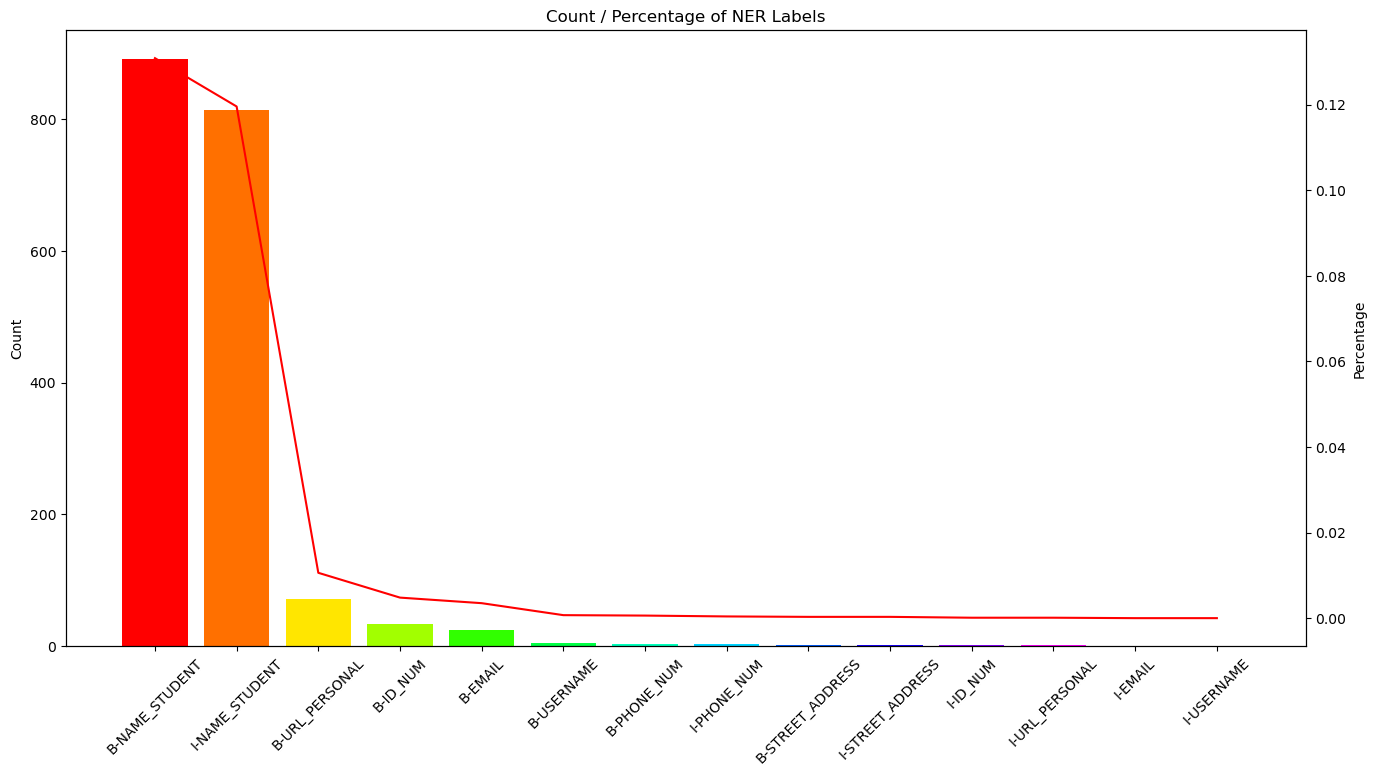

In [18]:
plot_ner_distribution(ner_labels_stat, 'doc_count', 'doc_count_percentage')

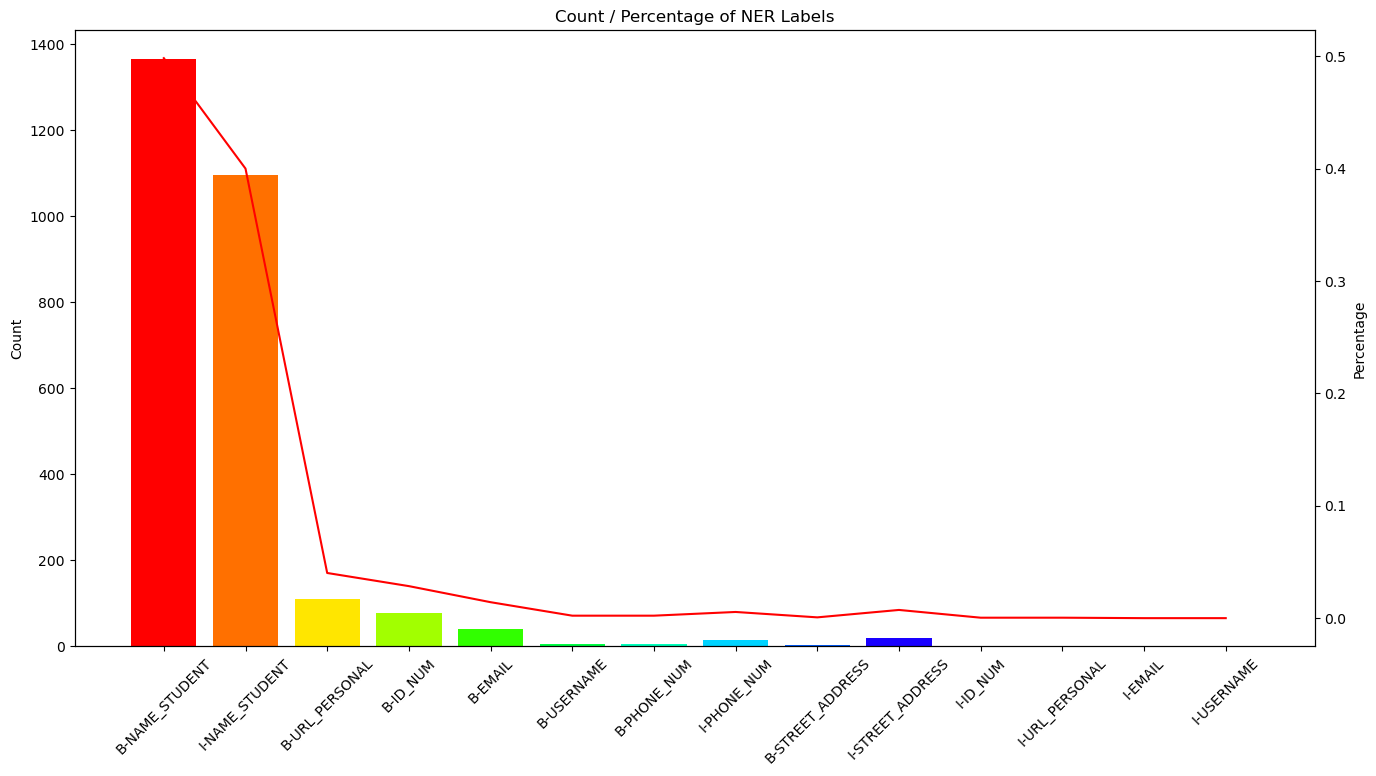

In [19]:
plot_ner_distribution(ner_labels_stat, 'ner_count', 'ner_count_percentage')

## 3. Pre-Processing

In [20]:
PUNCTUATION = set(punctuation)
STOPWORDS = set(stopwords.words("english"))

def lowercase(tokens):
    return [token.lower() for token in tokens]

def remove_stopwords(tokens):
    stop_words = set(stopwords.words("english"))
    return [token for token in tokens if token.lower() not in stop_words]

def remove_punctuation(tokens):
    return [''.join(ch for ch in token if ch not in PUNCTUATION) for token in tokens]

def remove_empty_and_newline(tokens):
    return [token for token in tokens if token.strip() != '' and token.strip() != ' \n\n']

def preprocess(tokens):
    tokens = lowercase(tokens)
    tokens = remove_punctuation(tokens)
    tokens = remove_stopwords(tokens)
    tokens = remove_empty_and_newline(tokens)
    return tokens

In [21]:
train_df['tokens_processed'] = train_df['tokens'].apply(preprocess)
train_df['tokens_count'] = train_df['tokens'].map(len)
train_df.head()

,document,full_text,tokens,trailing_whitespace,labels,tokens_processed,tokens_count
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-...","[design, thinking, innovation, reflexion, avri...",753
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...","[diego, estrada, design, thinking, assignment,...",563
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O...","[reporting, process, gilberto, gamboa, challen...",729
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT...","[design, thinking, innovation, sindy, samaca, ...",1071
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST...","[assignment, visualization, reflection, submit...",1927


In [22]:
test_df['tokens_processed'] = test_df['tokens'].apply(preprocess)
test_df['tokens_count'] = test_df['tokens'].map(len)
test_df.head()

,document,full_text,tokens,trailing_whitespace,tokens_processed,tokens_count
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[design, thinking, innovation, reflexion, avri...",753
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[diego, estrada, design, thinking, assignment,...",563
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[reporting, process, gilberto, gamboa, challen...",729
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[design, thinking, innovation, sindy, samaca, ...",1071
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[assignment, visualization, reflection, submit...",1927


In [23]:
def descriptive_stats(tokens, top_tokens=5, verbose=True):
    """
    Calculate descriptive statistics for a list of tokens.
    Args:
        tokens (list): List of tokens.
        top_tokens (int): Number of top tokens to display.
        verbose (bool): Print statistics if True.
    Returns:
        list: A list containing [num_tokens, num_unique_tokens, lexical_diversity, num_characters]
    """
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(token) for token in tokens)
    token_counter = Counter(tokens)
    most_common_tokens = token_counter.most_common(top_tokens)

    if verbose:
        print(f"Number of tokens: {num_tokens}")
        print(f"Number of unique tokens: {num_unique_tokens}")
        print(f"Number of characters: {num_characters}")
        print(f"Lexical diversity: {lexical_diversity:.3f}")
        print(f"Most common tokens (Top {top_tokens}):")
        for token, count in most_common_tokens:
            print(f" - {token}: {count}")

    return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]

In [24]:
train_tokens = train_df['tokens_processed'].sum()
train_stats = descriptive_stats(train_tokens)

Number of tokens: 2225629
Number of unique tokens: 41804
Number of characters: 14598461
Lexical diversity: 0.019
Most common tokens (Top 5):
 - tool: 19479
 - team: 13522
 - design: 13260
 - would: 13077
 - challenge: 12704


In [25]:
test_tokens = test_df['tokens_processed'].sum()
test_stats = descriptive_stats(test_tokens)

Number of tokens: 3377
Number of unique tokens: 1501
Number of characters: 22651
Lexical diversity: 0.444
Most common tokens (Top 5):
 - tool: 34
 - would: 31
 - people: 29
 - money: 21
 - company: 20


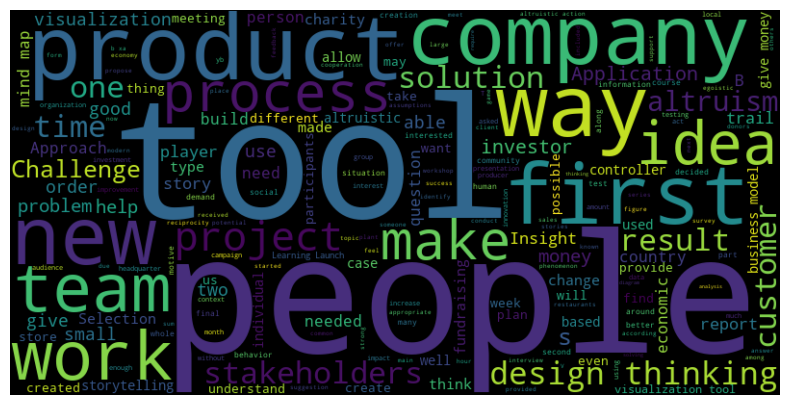

In [26]:
from wordcloud import WordCloud

# Wordcloud for test_df
all_tokens = ' '.join([token for sublist in test_df['tokens'] for token in sublist])
wordcloud = WordCloud(width=800, height=400).generate(all_tokens)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

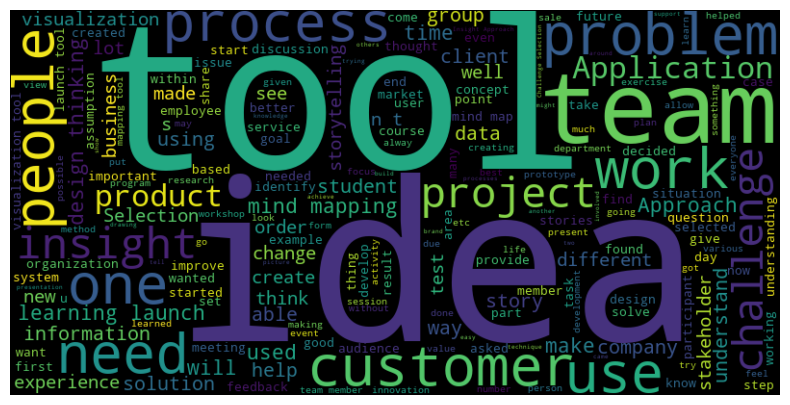

In [27]:
all_tokens = ' '.join([token for sublist in train_df['tokens'] for token in sublist])
wordcloud = WordCloud(width=800, height=400).generate(all_tokens)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: >

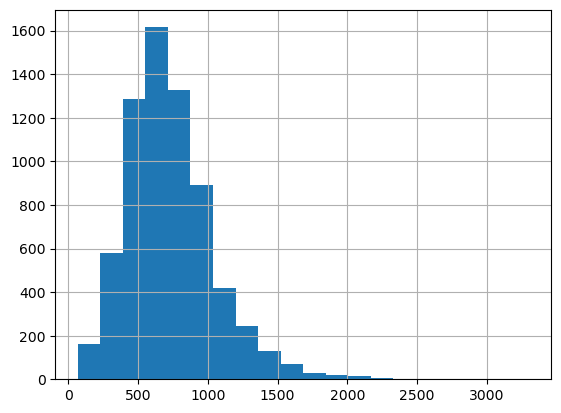

In [28]:
train_df['token_length'] = train_df['tokens'].apply(len)
train_df['token_length'].hist(bins=20)

In [30]:
#Submission Sample Removed
#label_freq_by_doc = submission_df.groupby('document')['label'].value_counts()
#label_freq_by_doc.head()